[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/comp-neural-circuits/plasticity-workshop/blob/dev/stdp.ipynb)

# Spike timing dependent plasticity (STDP) rules

Welcome to the second day of the plasticity tutorial! Today is all about *timing*!

In this tutorial you will learn:
- how the temporal order of pre- and postsynaptic spikes influences the change in the synaptic connection and how different parameters shape the **pairwise STDP rule**;
- how to generate **spike trains** and how to **keep track** of pre- and postsynaptic spikes over time, by using specific functions.
- how to generalise the points above to the **triplet STDP rule**.
- how the pairwise and the triplet STDP rule fit some **experimental data**. Do you have any guess on which one matches better the data? :)  
- how to implement the **inhibitory plasticity**, and how it influences the postsynaptic firing rate and the membrane currents.

So, let's start! Please, just run the cell below to initialize.

## Initialization

In [37]:
!pip install numpy scipy matplotlib ipywidgets scikit-learn --quiet
import numpy as np
import scipy.linalg as lin
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.style.use("https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/plots_style.txt")

## 1. The pairwise STDP rule

#### Coding Exercise 1: the pairwise STDP function

Let's begin by visualizing the **pairwise spike timing dependent plasticity (STDP) rule**. 
Recall that, under this rule, the synaptic weight increases (*long-term potentiation*) if a postsynaptic spike follows a presynaptic spike within a short time window, whereas the synaptic weight decreases (*long-term depression*) if the opposite occurs: 

$$
\Delta W (\Delta t) = \begin{cases}
A_+e^{-\Delta t/\tau_+} & \text{if } \Delta t\geq 0 \\
-A_-e^{\Delta t/\tau_-} & \text{if } \Delta t<0
\end{cases}
$$

where $A_+, A_-$ are positive constants. 

In the following exercise, you will fill a function script for the pairwise STDP rule.
Consider the time difference $\Delta t = t_{post} - t_{pre}$ between a post- and a presynaptic spike and compute the weight change $\Delta W$ as a function of $\Delta t$.

In [30]:
def DeltaW_pairSTDP(A_plus, A_minus, tau_plus, tau_minus):
    """    
    Args: 
    A_plus : maximum amount of potentiation (LTP)
    A_minus: maximum amount of depression (LTD)
    tau_plus: LTP time constant
    tau_minus: LTD time constant 
    
    Returns the instantaneous change in weights DeltaW due to the pairwise STDP rule
    """
    
    # Define the array with the time differences between post- and pre-synaptic spikes
    Delta_t = np.linspace(-5 * tau_minus, 5 * tau_plus, 50)
    # Initialize the STDP change
    DeltaW = np.zeros(len(Delta_t))
    # Calculate DeltaW for LTP
    DeltaW[Delta_t > 0] = A_plus * np.exp(-Delta_t[Delta_t > 0] / tau_plus)
    # Calculate DeltaW for LTD
    DeltaW[Delta_t <= 0] = -A_minus * np.exp(Delta_t[Delta_t <= 0] / tau_minus)

    return DeltaW

##### Visualization of the pairwise STDP function

In [38]:
def pairSTDP_plot(A_plus, A_minus, tau_plus, tau_minus):
    '''
    Args:
    A_plus : maximum amount of potentiation (LTP)
    A_minus: maximum amount of depression (LTD)
    tau_plus: LTP time constant
    tau_minus: LTD time constant 
    
    Generates a plot for the pairwise STDP rule
    '''
    # Define the array with the time differences between post- and pre-synaptic spikes
    Delta_t = np.linspace(-200, 200, 50)
    
    # Calculate the synaptic change
    DeltaW = DeltaW_pairSTDP(A_plus, A_minus, tau_plus, tau_minus)
    DeltaW = 100*DeltaW/np.max(np.abs(DeltaW))
    
    # Plot
    plt.figure(figsize=(8,6))
    plt.plot([Delta_t[0], Delta_t[-1]], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-100, 100], 'k', linestyle=':')

    plt.plot(Delta_t[Delta_t <= 0], DeltaW[Delta_t <= 0], 'r')
    plt.plot(Delta_t[Delta_t > 0], DeltaW[Delta_t > 0], 'b')

    plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)',fontsize=16)
    plt.ylabel(r'$\Delta $W (%)')
    plt.title('The Pairwise STDP rule', fontsize=18, fontweight='bold')
    plt.show()

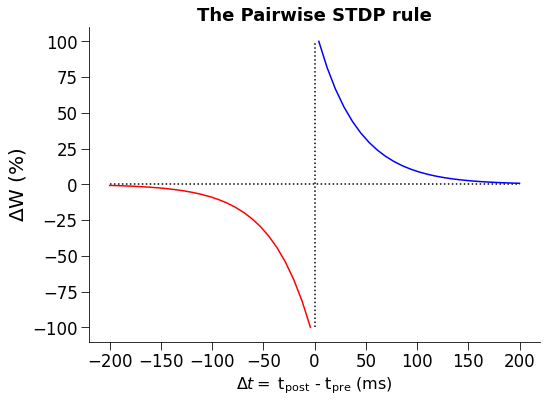

In [39]:
# Define the STDP rule parameters
A_plus = 10    # maximum amount of potentiation (LTP)
A_minus = 10   # maximum amount of potentiation (LTD)
tau_plus = 20  # LTP time constant [ms]
tau_minus = 20 # LTD time constant [ms]

# Plot the pairwise STDP function 
pairSTDP_plot(A_plus, A_minus, tau_plus, tau_minus)

##### Playing with the pairwise STDP function

After plotting and visualising the pairwise STDP rule for some specific values, you can see how changing some values changes 

How do the temporal constants and the amplitude values shape the STDP window? What can you tell about the influence of these parameters on the synaptic change?

Bonus question: what do you think will happen if we reverse ..

In [40]:
interact(pairSTDP_plot, A_plus = (0.1,2,0.01), A_minus = (0.1,2,0.01), tau_plus = (10,70,0.1), tau_minus  = (10,70,0.1));

interactive(children=(FloatSlider(value=1.05, description='A_plus', max=2.0, min=0.1, step=0.01), FloatSlider(…

## 2. Pre- and postsynaptic event detectors and spike trains 

Good job so far! You will now deepen the analysis of the pairwise STDP rule by visualising how the synaptic change is related to two specific spike trains (pre- and post), which are generated randomly under the Poisson distribution. This probabilistic distribution is commonly used for simulating spike trains.

##### Poisson spike train 

The next function generates a train of spikes drawn from the Poisson distribution. The output will be an array of binary values: the array will take the value 1 at time *t* if there was a spike at time *t*, 0 otherwise.

You can just run the cell below, however if you have extra time you can check how this is implemented. 

In [35]:
def Poisson_spike_train(discretization_step, t_range, rate, myseed=False):
    """
    Generates a Poisson train
    Args:
    discretization_step    : discretization time step
    t_range                : time interval
    rate                   : noise amplitute [Hz]
    myseed                 : random seed. int or boolean

    Returns:
    poisson_train : spike train of binary values (1 if spike, 0 otherwise)
    """
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate an uniformly distributed random variable
    unirnd = np.random.rand(len(t_range))

    # generate Poisson train
    poisson_train = 1. * (unirnd < rate * (discretization_step/1000.))

    return poisson_train

#### Coding exercise 2: keeping track

....Explain....

In [36]:
# Define the STDP rule parameters
A_plus = 10       # maximum amount of potentiation (LTP)
A_minus = 10      # maximum amount of potentiation (LTD)
tau_plus = 20  # LTP time constant [s]
tau_minus = 20 # LTD time constant [s]
discretization_step=0.1 # discretization time step
t_range=np.arange(0,1000,discretization_step)     # time interval

# Generate a presynaptic spike train
pre_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=7)
# Generate a postsynaptic spike train
post_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=1)

# Initialize the pre- and postsynaptic event detectors
r1 = np.zeros(len(t_range))        # presynaptic event detector
o1 = np.zeros(len(t_range))        # postsynaptic event detector

# Initialize the synaptic weight
w = np.ones(len(t_range))

# Keeping track of the detectors
for i in range(len(t_range)-1):
    if i==0:
        continue
    w[i]=w[i-1]
    
    if pre_spike[i]==1:     # there is a pre-synaptic spike
        r1[i] += 1
        if i==0:
            continue
        w[i] = w[i-1] - o1[i]*A_minus
            
    if post_spike[i]==1:    # there is a post-synaptic spike
        o1[i] += 1
        if i==0:
            continue
        w[i] = w[i-1] + r1[i]*A_plus
    
        
    # Apply Euler's method to the detector equations
    r1[i+1] = r1[i] - discretization_step * r1[i]/tau_plus
    o1[i+1] = o1[i] - discretization_step * o1[i]/tau_minus
w[-1]=w[-2]

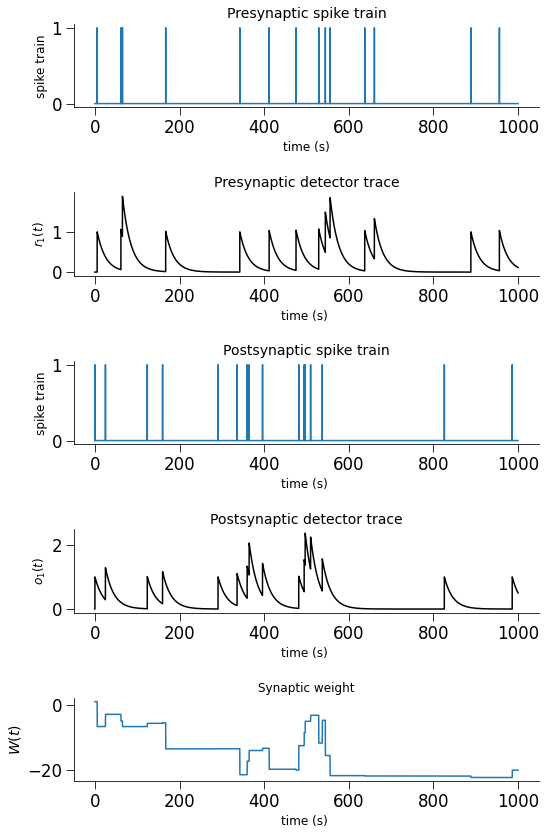

In [8]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, figsize=(8,12)); #gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(t_range,pre_spike);
ax1.set_xlabel("time (s)", fontsize=12);
ax1.set_ylabel("spike train", fontsize=12);
ax1.set_title("Presynaptic spike train", fontsize=14);
ax2.plot(t_range,r1,color="black");
ax2.set_xlabel("time (s) ", fontsize=12);
ax2.set_ylabel("$r_1(t)$", fontsize=12);
ax2.set_title("Presynaptic detector trace", fontsize=14);
ax3.plot(t_range,post_spike);
ax3.set_xlabel("time (s) ", fontsize=12);
ax3.set_ylabel('spike train', fontsize=12);
ax3.set_title("Postsynaptic spike train", fontsize=14);
ax4.plot(t_range,o1,color="black");
ax4.set_xlabel("time (s) ", fontsize=12);
ax4.set_ylabel('$o_1(t)$', fontsize=12);
ax4.set_title("Postsynaptic detector trace", fontsize=14);
ax5.plot(t_range,w);
ax5.set_xlabel("time (s) ", fontsize=12);
ax5.set_ylabel('$W(t)$', fontsize=14);
ax5.set_title("Synaptic weight", fontsize=12);

## 3. The triplet STDP rule

Let's now turn to the **triplet spike timing dependent plasticity (STDP) rule**, which uses sets of three spikes to induce *long term potentiation*, and pairs of spikes to induce *long term depression*.

Recall that, under this rule, potentiation depends on the interval $\Delta t_1$ between the pre- and postsynaptic spikes, and on the timing $\Delta t_2$ of the previous postsynaptic spike, whereas *long-term depression* depends only on $\Delta t_1$.

$$
\Delta W (\Delta t) = \begin{cases}
A_+e^{-\Delta t_1/\tau_+}e^{-\Delta t_2/\tau_y} & \text{if } \Delta t_1\geq 0, \Delta t_2\geq 0 \\
-A_-e^{\Delta t/\tau_-} & \text{if } \Delta t_1<0
\end{cases}
$$

where $\Delta t_1 = t_{post} - t_{pre}$ denotes the time difference between a post- and a presynaptic spike and $\Delta t_2 = t_{post} - t'_{post}$ denotes the time difference between two postpresynaptic spikes.

In the following exercise, you will fill a function script for the triplet STDP rule.
Consider the time difference $\Delta t_1$ between a post- and a presynaptic spike and compute the weight change $\Delta W$ as a function of $\Delta t_1$ for a given value of $\Delta t_2$.

#### Coding Exercise 3: the triplet STDP function

In [9]:
def DeltaW_tripSTDP(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2):
    """
    Calculates the instantaneous change in weights dW due to the STDP pairwise rule

    A_plus : maximum amount of potentiation (LTP)
    A_minus: maximum amount of depression (LTD)
    tau_plus: LTP time constant
    tau_minus: LTD time constant 
    Delta_t1 : array with the time differences between the first postsynaptic spike and the presynaptic spike
    Delta_t2 : array with the time differences between the postsynaptic spikes 
    
    Returns the instantaneous change in weights DeltaW due to the triplet STDP rule
    """
    # Define the array with the time differences between the first postsynaptic spike and the presynaptic spike
    Delta_t1 = np.linspace(-5 * tau_minus, 5 * tau_plus, 50)
    # Initialize the STDP change
    DeltaW = np.zeros(len(Delta_t1))
    # Calculate dW for LTP
    DeltaW[Delta_t1 > 0] = A_plus * np.exp(-Delta_t1[Delta_t1 > 0] / tau_plus) * np.exp(-Delta_t2 / tau_y)
    # Calculate dW for LTD
    DeltaW[Delta_t1 <= 0] = -A_minus * np.exp(Delta_t1[Delta_t1 <= 0] / tau_minus)

    return DeltaW

##### Visualization of the triplet STDP function

In [10]:
def tripletSTDP_plot(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2):
    '''
    Generates a plot for the triplet STDP rule

    A_plus : maximum amount of potentiation (LTP)
    A_minus: maximum amount of depression (LTD)
    tau_plus: LTP time constant
    tau_minus: LTD time constant 
    tau_y: second LTP time constant
    Delta_t2 : array with the time differences between the postsynaptic spikes  
    
    Generates a plot for the triplet STDP rule
    '''
    # Define the array with the time differences between the first postsynaptic spike and the presynaptic spike
    Delta_t1 = np.linspace(-5 * tau_minus, 5 * tau_plus, 50)

    # Calculate the synaptic change
    DeltaW = DeltaW_tripSTDP(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2)
    DeltaW = 100*DeltaW/np.max(np.abs(DeltaW))
    
    plt.figure(figsize=(8,6))
    plt.plot([Delta_t1[0], Delta_t1[-1]], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-100, 100], 'k', linestyle=':')

    plt.plot(Delta_t1[Delta_t1 <= 0], DeltaW[Delta_t1 <= 0], 'r')
    plt.plot(Delta_t1[Delta_t1 > 0], DeltaW[Delta_t1 > 0], 'b')

    plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)',fontsize = 16)
    plt.ylabel(r'$\Delta $W (%)')
    plt.title('The triplet STDP rule', fontsize=18, fontweight='bold')
    plt.show()

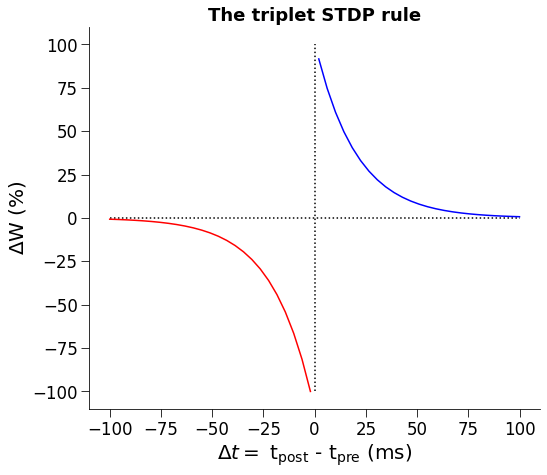

In [11]:
# define the STDP rule parameters
A_plus = 1
A_minus = 1
tau_plus = 20  #[ms]
tau_minus = 20 #[ms]
tau_y = 114 #[ms]
Delta_t2 = 10

DeltaW = DeltaW_tripSTDP(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2)
tripletSTDP_plot(A_plus, A_minus, tau_plus, tau_minus, tau_y, Delta_t2)

##### Playing with the triplet STDP function

To do: interactive plot with varying Delta t2 only

In [12]:
interact(tripletSTDP_plot, A_plus=fixed(1), A_minus=fixed(1), tau_plus= fixed(20), tau_minus= fixed(20), tau_y= fixed(114), Delta_t2 = (0.1,100,0.1));

interactive(children=(FloatSlider(value=50.00000000000001, description='Delta_t2', min=0.1), Output()), _dom_c…

## 4. Detector traces and spike trains 
study only the case of 1 pre- and 1 postsynaptic neuron (Poisson neurons).

#### Coding exercise 4: keeping track

In [13]:
tau_plus = 20  #[ms]
tau_minus = 20 #[ms]
tau_y = 114 #[ms]

discretization_step=0.1
t_range=np.arange(0,1000,discretization_step)
pre_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=7)
post_spike = Poisson_spike_train(discretization_step, t_range, rate=15, myseed=1)

#pre_spike = np.reshape(pre_spike, len(t_range))

r1=np.zeros(len(t_range))        # presynaptic event detector
o1=np.zeros(len(t_range))        # postsynaptic event detector
o2=np.zeros(len(t_range))        # postsynaptic event detector

# Initialize the synaptic weight
w = np.ones(len(t_range))

for i in range(len(t_range)-1):
    if i==0:
        continue
    w[i]=w[i-1]
    
    if pre_spike[i]==1:     # there is a pre-synaptic spike
        r1[i] += 1
        if i==0:
            continue
        w[i] = w[i-1] - o1[i]*A_minus
            
    if post_spike[i]==1:    # there is a post-synaptic spike
        o1[i] += 1
        if i==0:
            continue
        w[i] = w[i-1] + r1[i]*A_plus*o2[i]
        o2[i] += 1
    # Apply Euler's method to the detector equations
    r1[i+1] = r1[i] - discretization_step * r1[i]/tau_plus
    o1[i+1] = o1[i] - discretization_step * o1[i]/tau_minus
    o2[i+1] = o2[i] - discretization_step * o2[i]/tau_y
w[-1]=w[-2]

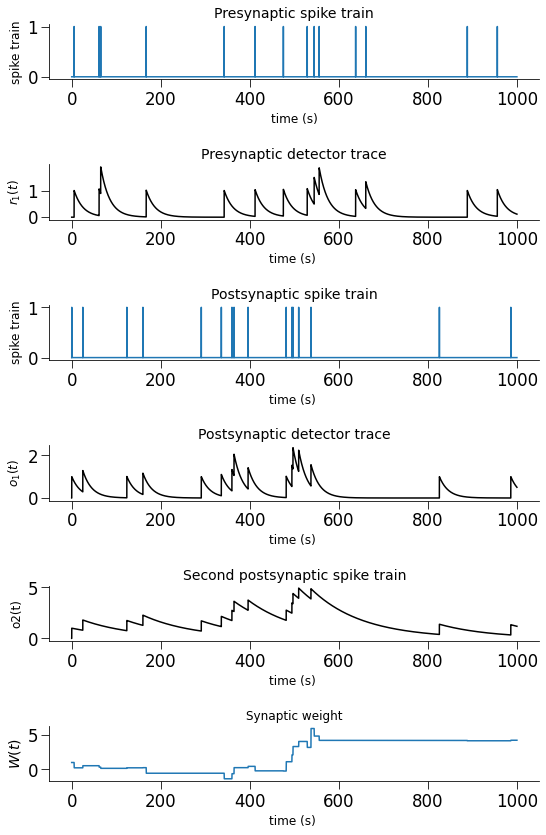

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6,1, figsize=(8,12)); #gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(t_range,pre_spike);
ax1.set_xlabel("time (s)", fontsize=12);
ax1.set_ylabel("spike train", fontsize=12);
ax1.set_title("Presynaptic spike train", fontsize=14);
ax2.plot(t_range,r1,color="black");
ax2.set_xlabel("time (s) ", fontsize=12);
ax2.set_ylabel("$r_1(t)$", fontsize=12);
ax2.set_title("Presynaptic detector trace", fontsize=14);
ax3.plot(t_range,post_spike);
ax3.set_xlabel("time (s) ", fontsize=12);
ax3.set_ylabel('spike train', fontsize=12);
ax3.set_title("Postsynaptic spike train", fontsize=14);
ax4.plot(t_range,o1,color="black");
ax4.set_xlabel("time (s) ", fontsize=12);
ax4.set_ylabel('$o_1(t)$', fontsize=12);
ax4.set_title("Postsynaptic detector trace", fontsize=14);
ax5.plot(t_range,o2,color="black");
ax5.set_xlabel("time (s) ", fontsize=12);
ax5.set_ylabel('o2(t)', fontsize=12);
ax5.set_title("Second postsynaptic spike train", fontsize=14);
ax6.plot(t_range,w);
ax6.set_xlabel("time (s) ", fontsize=12);
ax6.set_ylabel('$W(t)$', fontsize=14);
ax6.set_title("Synaptic weight", fontsize=12);

## 5. Pairing protocol analysis: matching the data

#### Helper function

In [15]:
'''
A fixed number of pairs of presynaptic and postsynaptic spikes shifted by DeltaT are elicited at regular intervals of 1/rho. 
Plot the synaptic change due to the triplet STDP as a function of the frequency rho for a fixed DeltaT.  
'''

def spike_trains(discretization_step, rho, num_pairs):

    '''Generates presynaptic and postsynaptic spike trains characterised by a number of pairs (given by 'num_pairs') of pre- and post-synaptic spikes with a given time distance 'DeltaT'.
    The pairs are repeated at a given frequency 'rho' 

    1) Generate two "small" arrays containing only one pair of one pre- and one post-synaptic spikes within a time window 1/rho. These will be the "building blocks" of the full spike trains.

    2) Construct the full spike trains by repeating the small arrays the number of times given by num_pairs.
    '''

    DeltaT = 1e-2   # time distance between pre- and postsynaptic spikes. It must be greater than the discretization_step!
    pair_distance = round(1/rho,2)   # time distance between pairs of pre-post spikes.

    # Generate the first piece of the pre- and postsynaptic spike trains (namely, one pair of pre- and post-synaptic spikes) within a time window 1/rho 
    small_t_range = np.arange(0,pair_distance - discretization_step,discretization_step)   # time interval between pairs of pre-post spikes.
    t_range=np.arange(0,num_pairs*(pair_distance - discretization_step),discretization_step)            # the whole time interval 

    first_spike = np.zeros(len(small_t_range))           # initialize the first piece of the pre-synaptic spike train 
    second_spike = np.zeros(len(small_t_range))          # initialize the first piece of the post-synaptic spike train
    first_spike[0] = 1                                   # generate a pre-syn spike at time 0 
    second_spike[np.where(small_t_range==DeltaT)[0]] = 1 # generate a post-syn spike after DeltaT
    first_spikes=np.tile(first_spike,num_pairs)             # repeat for 'num_pairs' times and create the full spike train
    second_spikes=np.tile(second_spike,num_pairs)           # repeat for 'num_pairs' times and create the full spike train
    return first_spikes, second_spikes, t_range

#### Coding exercise 5: pairing protocol with the pairwise STDP rule

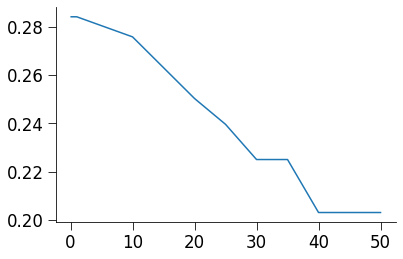

In [16]:
# Initialization 
num_pairs = 60      # number of pre- and post- pairs 
rho_vec = np.array([0.1, 1, 10, 20, 25, 30, 35, 40, 50])        # frequency values
discretization_step = 1e-4 # it must be less than the time difference within a pair of spikes DeltaT!
tau_plus = 16.8e-3             # LTP time constant (s)
tau_minus = 33.7e-3             # LTD time constant (s)
A_plus = 8.6e-3             # LTP window amplitude
A_minus = 2.1e-3            # LTD window amplitude
w0 = 3                     # initial weight

# initialize the synaptic change
DeltaW = np.zeros(len(rho_vec))    

for ind,rho in enumerate(rho_vec):
    # initialize the synaptic weight
    w=w0

    pre_spike, post_spike, t_range = spike_trains(discretization_step, rho, num_pairs)
    
    # CASE with DeltaT < 0
    # The case with DeltaT < 0 is equivalent to switch the pre- and the postsynaptic spike trains.
    # post_spike, pre_spike, t_range = spike_trains(discretization_step, rho, num_pairs)

# initialize the pre- and postsynaptic detectors
    r1=0    # presynaptic event detector
    o1=0    # postsynaptic event detector

    for i,t in enumerate(t_range):
        if pre_spike[i]==1:     # there is a pre-synaptic spike
            r1 += 1
            w = w - o1*A_minus
            
        if post_spike[i]==1:    # there is a post-synaptic spike
            o1 += 1
            w = w + r1*A_plus;           
        
        # Apply Euler's method to the detector equations
        r1 = r1 - discretization_step * r1/tau_plus
        o1 = o1 - discretization_step * o1/tau_minus

    # Calculate the weight change as a function of the frequency
    DeltaW[ind]= w-w0   

plt.figure(figsize=(6,4))
plt.plot(rho_vec,DeltaW)
plt.show()

#### Coding exercise 6: pairing protocol with the triplet STDP rule

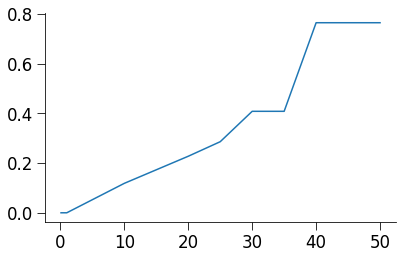

In [17]:
# Initialization 
num_pairs = 60      # number of pre- and post- pairs 
rho_vec = np.array([0.1, 1, 10, 20, 25, 30, 35, 40, 50])        # frequency values
discretization_step = 1e-4 # it must be less than the time difference within a pair of spikes DeltaT!
tau_plus = 16.8e-3             # LTP time constant (s)
tau_minus = 33.7e-3             # LTD time constant (s)
tau_y = 114e-3              # Second LTP time constant (s)
A_plus = 6.5e-3             # LTP window amplitude
A_minus = 7.1e-3            # LTD window amplitude
w0 = 3                     # initial weight

# initialize the synaptic change
dw = np.zeros(len(rho_vec))    

for ind,rho in enumerate(rho_vec):
    # initialize the synaptic weight
    w=w0

    pre_spike, post_spike, t_range = spike_trains(discretization_step, rho, num_pairs)
    
    # CASE with DeltaT < 0
    # The case with DeltaT < 0 is equivalent to switch the pre- and the postsynaptic spike trains.
    # post_spike, pre_spike, t_range = spike_trains(discretization_step, rho, num_pairs)

# initialize the pre- and postsynaptic detectors
    r1=0    # presynaptic event detector
    o1=0    # postsynaptic event detector
    o2=0    # second postsynaptic event detector

    for i,t in enumerate(t_range):
        if pre_spike[i]==1:     # there is a pre-synaptic spike
            r1 += 1
            w = w - o1*A_minus
            
        if post_spike[i]==1:    # there is a post-synaptic spike
            o1 += 1
            w = w + r1*(A_plus*o2);           
            o2=o2+1
        
        # Apply Euler's method to the detector equations
        r1 = r1 - discretization_step * r1/tau_plus
        o1 = o1 - discretization_step * o1/tau_minus
        o2 = o2 - discretization_step * o2/tau_y

    # Calculate the weight change as a function of the frequency
    DeltaW[ind]= w-w0   

plt.figure(figsize=(6,4))
plt.plot(rho_vec,DeltaW)
plt.show()

## 6. Inhibitory plasticity

explain...

#### Coding exercise 7: the inhibitory STDP function 

In [18]:
def DeltaW_inhSTDP(eta, rho, tau):
    """    
    Args: 
    eta : 
    rho: 
    tau: 
    
    Returns 
    DeltaW(1D- array) : the instantaneous weight change due to the inhibitory STDP rule
    """
    
    # Define the array with the time differences between post- and pre-synaptic spikes
    Delta_t = np.linspace(-100, 100, 200)
    # Initialize the STDP change
    DeltaW = np.zeros(len(Delta_t))
    # Calculate DeltaW
    DeltaW = eta * ( (1/(2*tau)) * np.exp(-np.abs(Delta_t)/tau) - rho)
    DeltaW = 100*DeltaW/np.max(DeltaW)

    return DeltaW

In [19]:
def inhSTDP_plot(eta, rho, tau):
    """    
    Args: 
    eta : 
    rho: 
    tau: 
    
    Generates a plot for the inhibitory STDP rule
    """
    
    # Define the array with the time differences between post- and pre-synaptic spikes
    Delta_t = np.linspace(-100, 100, 200)
    
    # Calculate the synaptic change
    DeltaW = DeltaW_inhSTDP(eta, rho, tau)
    
    # Plot
    plt.figure(figsize=(8,5))
    plt.plot([Delta_t[0], Delta_t[-1]], [0, 0], 'k', linestyle=':')
    plt.plot([0, 0], [-20, 100], 'k', linestyle=':')

    plt.plot(Delta_t, DeltaW, 'r')

    plt.xlabel(r'$\Delta t=$ t$_{\mathrm{post}}$ - t$_{\mathrm{pre}}$ (ms)',fontsize=16)
    plt.ylabel(r'$\Delta $W (%)',fontsize=16)
    plt.title('The inhibitory STDP rule', fontsize=18, fontweight='bold')
    plt.show()

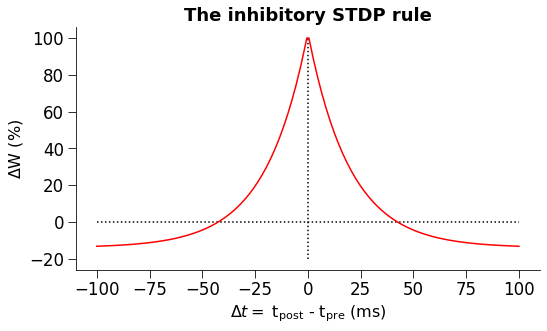

In [20]:
# Define the STDP rule parameters
eta = 1e-4
rho = 3e-3
tau = 20

# Plot the pairwise STDP function 
inhSTDP_plot(eta, rho, tau)

**TO DO** Temporal evolution of the postsynaptic firing rate and the average synaptic weights of the inhibitory synapses

 Total excitatory, inhibitory, and net (green) membrane currents before, during, and after inhibitory synaptic plasticity.

In [21]:
dt = 0.1
duration=1000 # duration of a small interval in ms  
num_small_intervals=60
range_t=np.arange(0,num_small_intervals*duration,dt)            # the whole time interval 
rate = 60
n = 100
exc = int(0.8 * n)
tauExc = 5
tauInh = 10
tauPlasticity = 20
gBarExc = 0.14
gBarInh = 0.35
VRest=-60
Vth=-50
taumem=20
EGABA=-80
eta = 0.01
alpha = 0.25 * eta
tRef = 5

W=np.zeros(n)
np.random.seed(7)
W[0:exc] =  (1.1 + np.random.random(exc))
W[exc:n] = 0.1

input_spiketrains = np.zeros((n, len(range_t)))
for s in range(n):
    input_spiketrains[s,:] = Poisson_spike_train(dt, range_t, rate, s)
post_spike_count = 0
post_rate = 0
post_spike = np.zeros(len(range_t))

gExc = 0
gInh = 0
gLeak = 1
r1 = np.zeros(n)
o1 = 0
save_inh_weights = np.zeros(len(range_t))
tolos = 0 

V = np.zeros(len(range_t))
o1_overtime = np.zeros(len(range_t))
Exkeep= np.zeros(len(range_t))
Inkeep = np.zeros(len(range_t))
V[0]=VRest

for ind,t in enumerate(range_t):
    if ind == len(range_t)-1:
        break
    if ind == 0:
        continue
    gExc = gExc - dt/tauExc * gExc 
    gInh = gInh - dt/tauInh * gInh

    for s in range(exc,n):
        r1[s] = r1[s] - dt/tauPlasticity * r1[s]
    o1 = o1 - dt/tauPlasticity * o1

    for s in range(exc):
        if input_spiketrains[s, ind] == 1:
            gExc += (gBarExc * W[s])
    for s in range(exc,n):
        if input_spiketrains[s, ind] == 1:
            gInh = gInh + (gBarInh * W[s])    
            r1[s] += eta                    
            W[s] = W[s] + o1 - alpha                # plasticity
            if W[s] < 0:
                W[s] = 0 
    # postsynaptic neuron 
    if ((t - tolos) < tRef):
        V[ind] = VRest
    else:
        gTot = gLeak + gExc + gInh
        tauEff = taumem/gTot  
        VInf = ((gLeak*VRest + gInh*EGABA)/gTot)
        V[ind] = VInf + (V[ind-1] - VInf)*np.exp(-dt/tauEff)
    if V[ind] >= Vth:
        tolos = t
        V[ind] = 0
        V[ind-1] = VRest
        o1 += eta
        post_spike_count += 1
        post_spike[ind] = 1
        for s in range(exc,n):
            W[s] += r1[s]   # plasticity
    Exkeep[ind] = gExc * V[ind]
    Inkeep[ind] = gInh * (V[ind] - EGABA)
    save_inh_weights[ind] = np.mean(W[exc:n])
    o1_overtime[ind] = o1

save_inh_weights[0]=save_inh_weights[1]
save_inh_weights[-1] = save_inh_weights[-2]
post_rate = np.zeros(num_small_intervals)
inh_weights = np.zeros(num_small_intervals)
avgExkeep = np.zeros(num_small_intervals)
avgInkeep = np.zeros(num_small_intervals)

for i in range(num_small_intervals):
    somma = sum(post_spike[i*duration:(i+1)*duration])
    post_rate[i] = somma/ duration * 1000
    inh_weights[i] = np.mean(save_inh_weights[i*duration:(i+1)*duration])
    avgExkeep[i] = np.mean(Exkeep[i*duration:(i+1)*duration])
    avgInkeep[i] = np.mean(Inkeep[i*duration:(i+1)*duration])


Exkeep0 = Exkeep[0:int(duration/10)]
Inkeep0 = Inkeep[0:int(duration/10)]
Exkeep1 = Exkeep[int(duration*(num_small_intervals-1/10)):duration*num_small_intervals]
Inkeep1 = Inkeep[int(duration*(num_small_intervals-1/10)):duration*num_small_intervals]

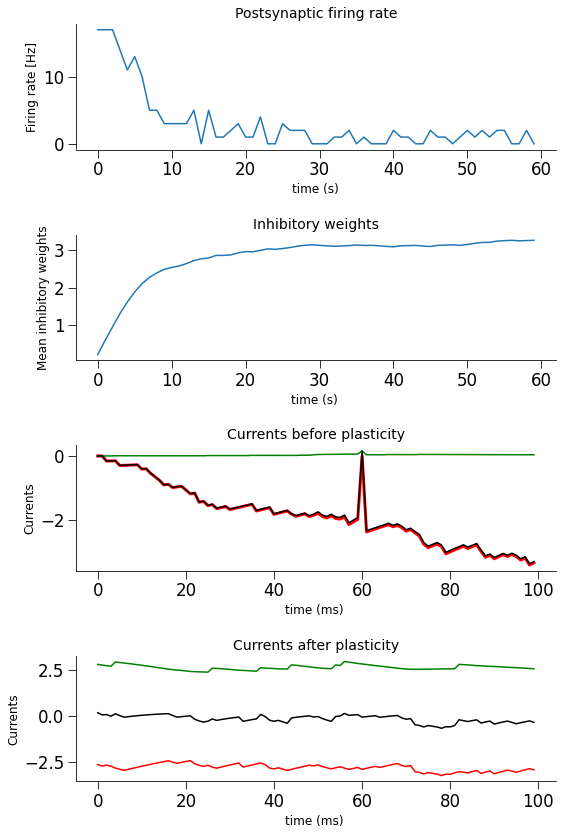

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,12));
ax1.plot(range(num_small_intervals),post_rate)
ax1.set_xlabel("time (s)", fontsize=12);
ax1.set_ylabel("Firing rate [Hz]", fontsize=12);
ax1.set_title("Postsynaptic firing rate", fontsize=14);
ax2.plot(range(num_small_intervals),inh_weights)
ax2.set_xlabel("time (s) ", fontsize=12);
ax2.set_ylabel("Mean inhibitory weights", fontsize=12);
ax2.set_title("Inhibitory weights", fontsize=14);
ax3.plot(range(int(duration/10)), Exkeep0/100,'r',linewidth=3)
ax3.plot(range(int(duration/10)), Inkeep0/100, 'g')
ax3.plot(range(int(duration/10)), (Inkeep0 + Exkeep0)/100, 'k')
ax3.set_xlabel("time (ms) ", fontsize=12);
ax3.set_ylabel('Currents', fontsize=12);
ax3.set_title("Currents before plasticity", fontsize=14);
ax4.plot(range(int(duration/10)), Exkeep1/100, 'r')
ax4.plot(range(int(duration/10)), Inkeep1/100, 'g')
ax4.plot(range(int(duration/10)), (Inkeep1 + Exkeep1)/100, 'k')
ax4.set_xlabel("time (ms) ", fontsize=12);
ax4.set_ylabel('Currents', fontsize=12);
ax4.set_title("Currents after plasticity", fontsize=14);